## Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [6]:
import warnings
warnings.filterwarnings("ignore")
# read the dataset
data = pd.read_csv('10.retail_sales.csv', index_col='Date', parse_dates=True)
print(data.head())


                         Sales
Date                          
2015-01-01 00:00:00  54.048619
2015-01-01 01:00:00  50.161596
2015-01-01 02:00:00  55.954939
2015-01-01 03:00:00  56.553261
2015-01-01 04:00:00  60.487874


In [11]:
# resampling time series Data to hourly frequency with pandas

data= data.asfreq('H')

In [12]:
# Check for stationarity and make the series stationary if needed

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

# Check stationarity
adf_test(data['Sales'])

# If the series is not stationary, difference the series
data_diff = data.diff().dropna()
adf_test(data_diff['Sales'])


ADF Statistic: -3.15354213292866
p-value: 0.022836314599436483
Critial Values:
   1%, -3.4304745025245373
Critial Values:
   5%, -2.861595027617222
Critial Values:
   10%, -2.5667992893705645
ADF Statistic: -35.52644623693404
p-value: 0.0
Critial Values:
   1%, -3.430474504895001
Critial Values:
   5%, -2.861595028664898
Critial Values:
   10%, -2.5667992899282113


#### p-value is smaller than 0.5 its stationary

In [13]:
# Scaling the data, i changed all time series range values 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff)

# Convert scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=['Sales'], index=data_diff.index)


In [15]:
#check range
scaled_data

,Sales
Date,
2015-01-01 01:00:00,0.492056
2015-01-01 02:00:00,0.714117
2015-01-01 03:00:00,0.594947
2015-01-01 04:00:00,0.671479
2015-01-01 05:00:00,0.587778
...,...
2020-12-30 20:00:00,0.538090
2020-12-30 21:00:00,0.687076
2020-12-30 22:00:00,0.556510


## Split the dataset into train and test sets

In [17]:
#  Split the dataset into train and test sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Convert data to sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data.iloc[i:i + sequence_length].values)
        labels.append(data.iloc[i + sequence_length].values)
    return np.array(sequences), np.array(labels)

sequence_length = 10  
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)


In [37]:
# check train ,test shape
print(X_train.shape)
print(y_test.shape)

(42057, 10, 1)
(10507, 1)


## Build the LSTM model

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Reshape the data to fit the LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0133 - val_loss: 0.0053
Epoch 2/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 3/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 4/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 5/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 6/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 7/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 8/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 10/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 11/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 12/50
1183/1183 ━━━━━━━

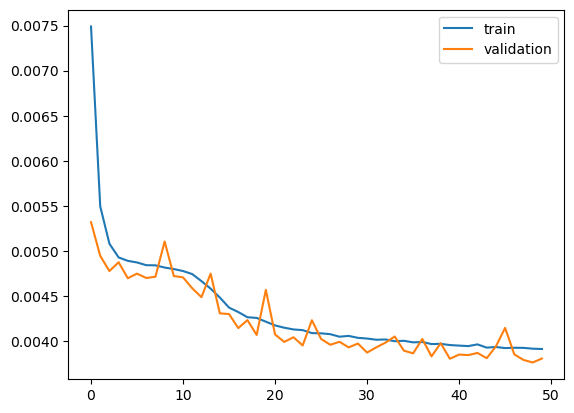

In [26]:
#plot the loss function
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


##  Forecasting the next 20 values


In [27]:
predictions = []
input_seq = X_test[-1]

for _ in range(20):
    pred = model.predict(input_seq.reshape((1, sequence_length, 1)))
    predictions.append(pred[0, 0])
    input_seq = np.append(input_seq[1:], pred)

# Invert scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [28]:
predictions

array([[ 2.1011865 ],
       [ 1.7895674 ],
       [ 1.852414  ],
       [ 1.7899493 ],
       [ 0.64547116],
       [ 2.1925268 ],
       [ 1.0371565 ],
       [ 0.3529447 ],
       [ 0.87982804],
       [-0.47315064],
       [-0.82700884],
       [-2.015771  ],
       [-2.6153407 ],
       [-2.6602197 ],
       [-2.8258915 ],
       [-2.6927488 ],
       [-2.5512702 ],
       [-2.2537446 ],
       [-1.7555914 ],
       [-0.55604625]], dtype=float32)

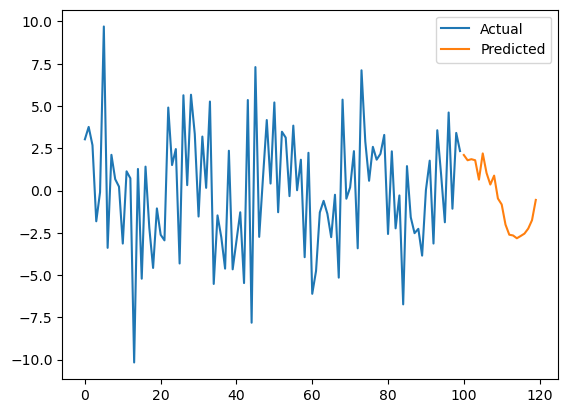

In [32]:
# Plot the actual values and predicted values
last_100_actual = actual[-100:]
actual_length = len(last_100_actual)

# Generate indices for the actual and predicted values
actual_indices = range(actual_length)
predicted_indices = range(actual_length, actual_length + len(predictions))

plt.plot(actual_indices, last_100_actual, label='Actual')
plt.plot(predicted_indices, predictions, label='Predicted')
plt.legend()
plt.show()


## Calculate mean_squared_error, mean_absolute_error, r2_score

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Only comparing the predicted part of the test set
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)
print('R^2 Score:', r2)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 7.438094178791806
Mean Absolute Error: 2.128246034136766
R^2 Score: 0.38400390139222174
